In [1]:
from torch_snippets import *

In [5]:
from torchvision import transforms
device ='cuda' if torch.cuda.is_available() else "cpu"
from torchvision.datasets import MNIST

device

'cuda'

In [6]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
    transforms.Lambda(lambda x : x.to(device))
])
trn_ds = MNIST("/content/" , transform = img_transform , train = True , download = True)
val_ds = MNIST('/content/' , transform =img_transform , train=False,download =True)

In [7]:
batch_size = 128
trn_dl = DataLoader(trn_ds , batch_size=batch_size,shuffle=True)
val_dl = DataLoader(val_ds , batch_size=batch_size , shuffle=True)

In [24]:
class ConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32 ,3 , stride=3 , padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2 , stride=2 ),
            nn.Conv2d(32 , 64 ,3,stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2 , stride= 1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64 ,32 ,3 , stride=2),
            nn.ReLU(True) , 
            nn.ConvTranspose2d(32,16,5 ,stride = 3 , padding =1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16,1,2,stride=2 ,padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x )
        x = self.decoder(x)
        return x
    

In [25]:
model = ConvolutionAutoEncoder().to(device)
from torchsummary import summary

In [26]:
summary(model , torch.zeros(2 ,1 ,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [27]:
def train_batch(input , model , criterion , optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output , input )
    loss.backward()
    optimizer.step()
    return loss

In [28]:
@torch.no_grad()
def validate_batch(input , model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output , input )
    return loss

In [30]:
model = ConvolutionAutoEncoder().to(device)
criterion  = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters() , lr = 0.001 , weight_decay=1e-5)


In [31]:
num_epochs = 5
log = Report(num_epochs)
for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data , _) in enumerate(trn_dl):
        loss = train_batch(data , model, criterion , optimizer)
        log.record(pos = (epoch + (ix+1)/N) , trn_loss = loss , end='\r')
    N = len(val_dl)
    for ix , (data ,_) in enumerate(val_dl):
        loss = validate_batch(data , model ,criterion)
        log.record(pos = (epoch+(ix+1)/N), val_loss = loss, end='\r')
    log.report_avgs(epoch+1)

C:\Program Files\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Program Files\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


EPOCH: 1.000  val_loss: 0.428  trn_loss: 0.472  (16.12s - 64.47s remaining)
EPOCH: 2.000  val_loss: 0.119  trn_loss: 0.315  (32.04s - 48.06s remaining)
EPOCH: 3.000  val_loss: 0.075  trn_loss: 0.091  (47.99s - 31.99s remaining)
EPOCH: 4.000  val_loss: 0.065  trn_loss: 0.072  (64.21s - 16.05s remaining)
EPOCH: 5.000  val_loss: 0.060  trn_loss: 0.064  (80.33s - 0.00s remaining)


100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 2465.36it/s]


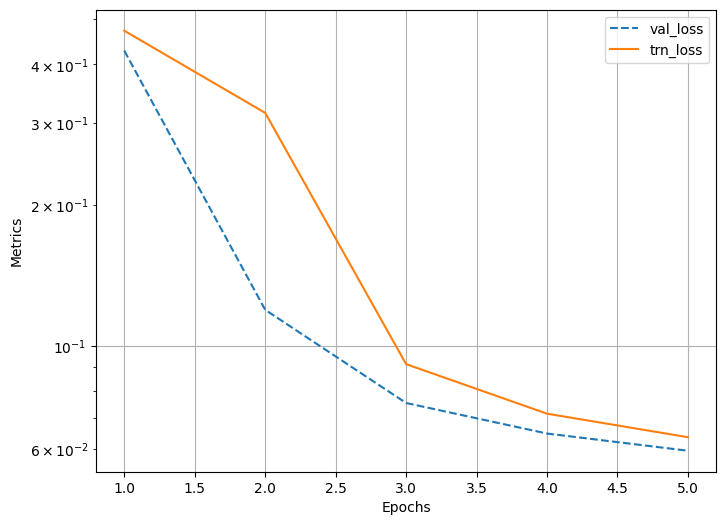

In [33]:
log.plot_epochs(log=True)

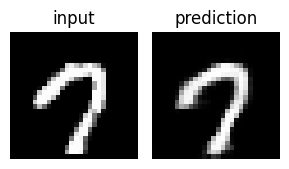

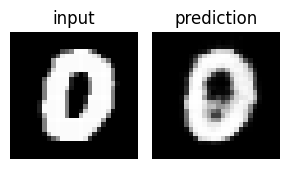

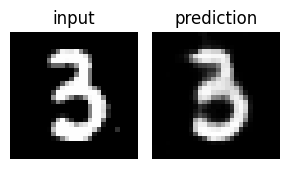

In [32]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im , _ = val_ds[ix]
    _im = model(im[None])[0]
    fig , ax = plt.subplots(1,2,figsize = (3,3))
    show(im[0] , ax = ax[0] , title = 'input')
    show(_im[0] , ax = ax[1], title = 'prediction')
    plt.tight_layout()
    plt.show()